**Блокнот по проведению word-level probing экспериментов**

In [1]:
%pip install transformers sentencepiece conllu numpy pandas scikit-learn torch matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu -O french_gender.conllu

--2023-04-26 18:32:42--  https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 645402 (630K) [text/plain]
Saving to: ‘french_gender.conllu’

french_gender.conll 100%[===================>] 630.28K  1.83MB/s    in 0.3s    

2023-04-26 18:32:42 (1.83 MB/s) - ‘french_gender.conllu’ saved [645402/645402]



In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # this is very important for sklearn to be one-threaded
import torch
import pandas as pd
import numpy as np
from transformers import CamembertModel, CamembertTokenizer, BertModel, BertTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/yulikdaniel/Desktop/My_Scripts/FKN/3/Project/WordProbing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the model

In [2]:
def get_pretrained(model_name, model_class=CamembertModel, tokenizer_class=CamembertTokenizer, device=DEVICE):
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, output_hidden_states=True)
    model = model.to(device)
    return model, tokenizer

model, tokenizer = get_pretrained('camembert-base')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def get_average_embs(sentence, layer_inds, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги предложений по слоям. Эмбеддинг предложения == усреднённые эмбеддинги токенов
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds]
        hidden_states = torch.squeeze(hidden_states, dim=1)
        hidden_states = hidden_states[:,1:-1]
        return hidden_states.mean(axis=1)

get_average_embs('vus', [1,2]).shape

torch.Size([2, 768])

In [4]:
class CamembertMergeTokens:
    def __init__(self, calculateEmbeddings=False):
        self.punct = 0
        self.apo = 0
        self.tokens = []
        self.calculateEmbeddings = calculateEmbeddings
        self.embeddings = []

    def finish(self, *args, **kwargs):
        result = (self.tokens, self.embeddings) if self.calculateEmbeddings else self.tokens
        self.__init__(*args, **kwargs)
        return result
    
    def is_punctuation(token):
        token = [x for x in token if x != "▁"]
        return all([x in ".,?!:;()\"" for x in token]) and len(token) != 0
    
    def is_apostrophe(token):
        return token == "\'"
    
    def next_token(self, token, embedding=None):
        if self.calculateEmbeddings and embedding is None:
            print("Missing features in next_token...")

        if CamembertMergeTokens.is_punctuation(token):
            self.punct = 1
        if CamembertMergeTokens.is_apostrophe(token):
            self.apo = 1

        if token.startswith(chr(9601)):
            self.tokens.append(token[1:])
            if self.calculateEmbeddings:
                self.embeddings.append(embedding)
        elif self.punct or self.apo == 2:
            self.tokens.append(token)
            if self.calculateEmbeddings:
                self.embeddings.append(embedding)
        else:
            self.tokens[-1] += token
            if self.calculateEmbeddings:
                self.embeddings[-1] += embedding
        
        if self.punct != 0:
            self.punct = (self.punct + 1) % 3
        if self.apo != 0:
            self.apo = (self.apo + 1) % 3

In [5]:
def get_word_features(toks, token_features, TokenMerger):
    """
    Принимает в качестве аргументов токенизированное предложение и выход модели на нём. Собирает из выхода по токенам выход по словам.
    """
    token_features = token_features[1:-1] # drop CLS and SEP tokens
    word_features = []
    MergeTokens = TokenMerger(calculateEmbeddings=True)
    for i in range(len(token_features)):
        MergeTokens.next_token(toks[i], token_features[i])
    return torch.stack(MergeTokens.finish()[1], dim=0)


def get_word_embs(sentence, word_inds, layer_inds, TokenMerger, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги слов по слоям. Эмбеддинг слова == усреднённые эмбеддинги токенов, на которые оно разбито (обычно 1 токен).
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        # print(tokenizer.convert_ids_to_tokens(tokenizer(sentence)["input_ids"]))
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds] # Convert tuple of layers to torch tensor
        hidden_states = torch.squeeze(hidden_states, dim=1) # Drop batch dimension which is equal to 1
        # hidden_states = hidden_states[1:] # Drop the input layer

        result = []
        toks = tokenizer.tokenize(sentence)
        for layer in hidden_states:
            result.append(get_word_features(toks, layer, TokenMerger)[word_inds])
        
        return torch.stack(result, dim=0)


text = "J'aime le camembert" #The word camembert is split into multiple tokens => this sentence is good for testing
# text = '''Pour pouvoir mener à bien sa politique dictatoriale, le régime marocain a besoin de stabilité interne pour affronter les "risques externes" engendrés par le conflit du Sahara Occidental.'''
res = get_word_embs(text, [0, 1], [0, 1, 2], CamembertMergeTokens)
res.size()

torch.Size([3, 2, 768])

In [6]:
def join_parsings(bert_tokenization, ud_tokenization, TokenMerger, verbose=False): # accepts two tokenizations and returns list of features for bert tokenization
    mergeTokens = TokenMerger()
    for item in bert_tokenization:
        mergeTokens.next_token(item)
    bert_words = mergeTokens.finish()

    ud_features = [[]]
    last_word, last_symbol = 0, 0
    skip_ids = -1
    orig_index = dict()
    for item in ud_tokenization:
        if type(item["id"]) is int and item["id"] <= skip_ids:
            continue

        if bert_words[last_word][last_symbol:].startswith(item["form"]):
            last_symbol += len(item["form"])
            ud_features[-1].append(item)

            if type(item["id"]) is not int:
                skip_ids = item["id"][2]
            else:
                orig_index[item["id"]] = len(ud_features) - 1

            if last_symbol == len(bert_words[last_word]): # We've reached the end in the current word
                if len(ud_features[-1]) == 0:
                    print("this is weird...")
                last_word, last_symbol = last_word + 1, 0 # Switch to the next word in bert tokenization
                ud_features.append([])
        else:
            if verbose:
                print("There has been a problem merging", bert_words, "with", ud_tokenization)
                print(bert_words[:last_word])
            return
    ud_features.pop() # Remove the last emtpy features list
    return bert_words, ud_features, orig_index

### Loading and parsing datasets

In [7]:
import conllu

In [36]:
# Token parser is a function mapping a list of lists of word features and a dictionary from original to current index (aka a sentence)
# to a list of lists of indices of words and a list of targets (aka a number of observations)
# [[feats1], [feats2], [feats3.1, feats3.2]], {1:0, 2:1, 3:2, 4:2} -> [[0, 2], [1, 2]], [0, 1]

def create_word_by_word_parser(allowed_upos, target_feature):
    return lambda feats, orig_index: \
        get_data_from_sentence_word_by_word(feats, \
                                            lambda feat: get_data_from_word(feat, allowed_upos, target_feature))


def get_data_from_sentence_word_by_word(feats, word_by_word_function):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        data = word_by_word_function(feats[ind])
        if data is not None:
            word_inds.append([ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(data)
    return word_inds, targets


def get_part_of_speech(feat):
    if len(feat) > 1:
        return None
    feat = feat[0]
    return feat["upos"]


def get_data_from_word(feat, allowed_upos, target_feature):
    if len(feat) > 1: # This is a multiword token, let's skip it for now
        return None
    feat = feat[0]
    if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
        return feat["feats"][target_feature]
    return None

def get_noun_adjective_dependencies(feats, orig_index):
    word_inds = []
    targets = []
    nouns = []
    for ind in range(len(feats)):
        if len(feats[ind]) > 1:
            continue
        word_feats = feats[ind][0]
        if word_feats["upos"] == "NOUN" or word_feats["upos"] == "PROPN":
            nouns.append(ind)
    for ind in range(len(feats)):
        if len(feats[ind]) > 1:
            continue
        word_feats = feats[ind][0]
        if word_feats["upos"] == "ADJ" and word_feats["deprel"] == "amod":
            if orig_index.get(word_feats["head"]) is not None and orig_index[word_feats["head"]] in nouns:
                word_inds.append([orig_index[word_feats["head"]], ind])
                targets.append(1)
                if len(nouns) != 1:
                    noun_he = nouns[(nouns.index(orig_index[word_feats["head"]]) + 1) % len(nouns)]
                    word_inds.append([noun_he, ind])
                    targets.append(0)

    return word_inds, targets

def get_word_by_word_with_distance(feats, allowed_upos, target_feature, distance, max_distance):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        if ind < max_distance or len(feats[ind]) != 1:
            continue
        feat = feats[ind][0]
        if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
            word_inds.append([ind - distance]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(feat["feats"][target_feature])
    return word_inds, targets

def get_word_by_word_with_tree_distance(feats, allowed_upos, target_feature, distance, max_distance):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        if ind < max_distance or len(feats[ind]) != 1:
            continue
        feat = feats[ind][0]
        if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
            word_inds.append([ind - distance]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(feat["feats"][target_feature])
    return word_inds, targets

In [9]:
def load_word_in_sentence_data(dataset_name, TokenMerger, features_extractor, verbose=False):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], [], []] # Gather data here, first list contains texts, second contains word indices, third contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats, orig_index = result
        word_inds, targets = features_extractor(feats, orig_index)

        if word_inds: # Let's not add sentences with no features to avoid vain embeddings calculation
            samples[0].append(sentence.metadata["text"])
            samples[1].append(word_inds)
            samples[2].append(targets)


    print(failed, "out of", total, "failed")
    data = pd.DataFrame.from_dict({"text": samples[0], "word_ind": samples[1], "target": samples[2]})
    return data


def load_separate_word_data(dataset_name, TokenMerger, features_extractor, verbose=False, sentences=-1):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], []] # Gather data here, first list contains word indices, second contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats, orig_index = result
        word_inds, targets = features_extractor(feats, orig_index)

        for ind in range(len(word_inds)):
            words = []
            for word_ind in word_inds[ind]:
                words.append(tokens[word_ind])
            samples[0].append(words)
            samples[1].append(targets[ind])

        sentences -= 1
        if sentences == 0:
            break


    print(failed, "out of", total, "failed")
    data = pd.DataFrame.from_dict({"word": samples[0], "target": samples[1]})
    return data


### Training the probing classifier

In [35]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from time import time


def logreg(args):
    layer, data = args
    X_train, X_test, y_train, y_test = data
    le = LogisticRegression(tol=0.01, max_iter=3000)
    le = le.fit(X_train, y_train)
    y_pred = le.predict(X_test)
    return layer, accuracy_score(y_test, y_pred), le.n_iter_[0]


def rerun_logregs(data, targets, runs, threads):
    res_ = []
    if threads == 1:
        for layer in range(data.shape[0]):
            t0 = time()
            for _ in range(runs):
                res_.append(logreg((layer, train_test_split(data[layer], targets, train_size=0.7))))
            print(f"Done layer #{layer}/{data.shape[0]} in {time() - t0}s")
    else:
        # We compute the inputs lazily, otherwise all RAM limits would be broken
        inputs = ((layer, train_test_split(data[layer], targets, train_size=0.7)) for run_i in range(runs) for layer in range(data.shape[0]))
        with Pool(threads) as pool:
            # It is important to use imap here and not map, since it avoids computing all inputs at once
            res_ = list(pool.imap(logreg, inputs, chunksize=1))
            # Bigger chunksize should supposedly improve performance, but it doesn't, maybe the tasks are too big for it to be noticeable,
            # however, it does introduce greater RAM usage, so it's not recommended to increase it

    res = [[] for _ in range(data.shape[0])]
    iter_nums = [[] for _ in range(data.shape[0])]
    for layer, acc, iters in res_:
        res[layer].append(acc)
        iter_nums[layer].append(iters)

    return res, iter_nums

In [11]:
def word_in_sentence_experiment(layers, TokenMerger, data_extractor, verbose=False, runs=1, threads=1):
    print("Loading sentences...")
    t1 = time()
    french_gender = load_word_in_sentence_data("french_gender.conllu", TokenMerger, data_extractor)
    all_embs = []
    all_targets = []
    print(f"Took {round(time() - t1)}s")
    print("Getting embeddings...")
    t1 = time()
    for row in french_gender.index:
        # french_gender.loc[row, "word_ind"] is a list of list of indices as there can
        # be multiple observations per sentence and multiple words per observation
        unique_words, indices = np.unique(np.concatenate(french_gender.loc[row, "word_ind"]), return_inverse=True)
        indices_per_obs = []
        sm = 0
        for observ in french_gender.loc[row, "word_ind"]:
            indices_per_obs.append(indices[sm : sm + len(observ)])
            sm += len(observ)

        embs = np.array(get_word_embs(french_gender.loc[row, "text"], unique_words, layers, CamembertMergeTokens).cpu())
        for observ in indices_per_obs:
            all_embs.append(np.concatenate(np.swapaxes(embs[:,observ], 0, 1), axis=1))

        all_targets += french_gender.loc[row, "target"]
    all_embs = np.swapaxes(np.stack(all_embs), 0, 1)
    all_targets = all_targets
    print(f"Got {all_embs.shape[0]} layers, {all_embs.shape[1]} entries in the dataset of width {all_embs.shape[2]}", flush=True)

    print(f"Took {round(time() - t1)}s")
    print("Training probing classifiers")
    t1 = time()

    res = rerun_logregs(all_embs, all_targets, runs, threads)

    print(f"Took {round(time() - t1)}s", flush=True)
    
    return res
    

In [12]:
def separate_word_experiment(layers, TokenMerger, data_extractor, verbose=False, runs=1, threads=1):
    print("Loading sentences...")
    t1 = time()
    french_gender = load_separate_word_data("french_gender.conllu", TokenMerger, data_extractor)
    print(f"Took {round(time() - t1)}s")

    print("Getting embeddings...")
    t1 = time()

    french_gender["feats"] = french_gender["word"].apply(lambda texts: torch.cat(tuple([get_average_embs(text, layers) for text in texts]), dim=1))
    all_embs = torch.stack(tuple(french_gender["feats"]), dim=0).permute([1,0,2]).cpu()

    print(f"Got {all_embs.shape[0]} layers, {all_embs.shape[1]} entries in the dataset of width {all_embs.shape[2]}")
    print(f"Took {round(time() - t1)}s")

    print("Training the probing classifiers")
    t1 = time()

    res = rerun_logregs(all_embs, french_gender["target"], runs, threads)

    print(f"Took {round(time() - t1)}s")

    return res

## Experiments

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

In [34]:
def show_results(quals, iternums, title):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.boxplot(quals, ax=axes[0]).set(xlabel="Layer", ylabel="Quality", title="Quality distribution by level")
    sns.boxplot(iternums, ax=axes[1]).set(xlabel="Layer", ylabel="Number of steps", title="Steps to convergence distribution")

In [50]:
number_parser = create_word_by_word_parser(["NOUN", "VERB", "ADJ"], "Number")
gender_parser = create_word_by_word_parser(["NOUN", "VERB", "ADJ"], "Gender")
pos_parser = lambda feats, _: get_data_from_sentence_word_by_word(feats, get_part_of_speech)
dep_parser = get_noun_adjective_dependencies
definite_parser = create_word_by_word_parser(["DET"], "Definite")
verb_tense_parser = create_word_by_word_parser(["VERB"], "Tense")
verb_person_parser = create_word_by_word_parser(["VERB"], "Person")
verb_mood_parser = create_word_by_word_parser(["VERB"], "Mood")
verb_form_parser = create_word_by_word_parser(["VERB"], "VerbForm")
pron_type_parser = create_word_by_word_parser(["PRON"], "PronType")

In [51]:
word_in_sentence_short = lambda parser: word_in_sentence_experiment(list(range(13)), CamembertMergeTokens, parser, runs=20, verbose=True, threads=8)
separate_word_short = lambda parser: separate_word_experiment(list(range(13)), CamembertMergeTokens, parser, runs=20, verbose=True, threads=8)

### Straightforward categorical experiments

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2700 entries in the dataset of width 768
Took 11s
Training probing classifiers
Took 7s


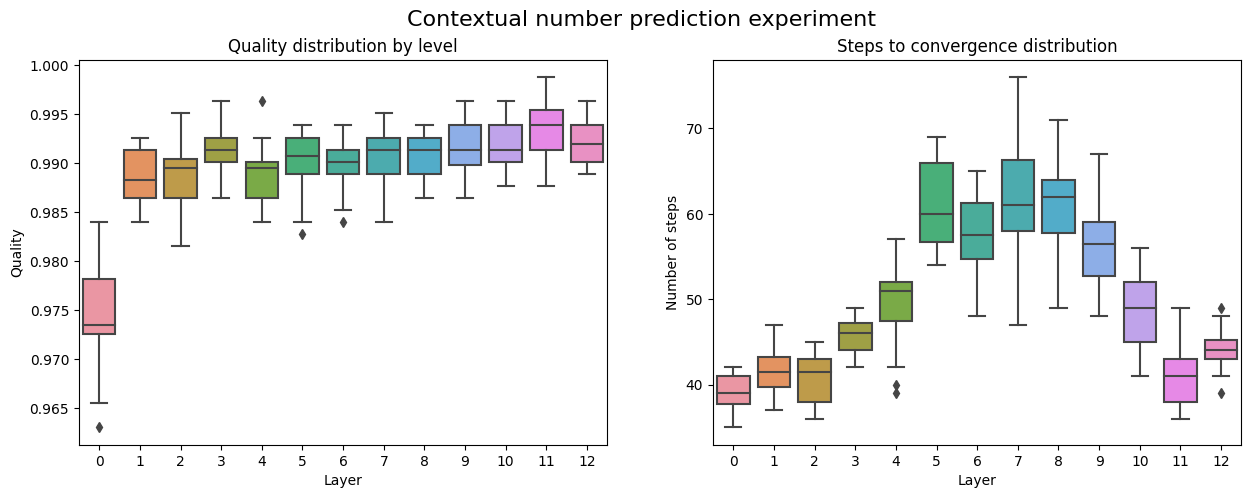

In [54]:
show_results(*word_in_sentence_short(number_parser),\
             "Contextual number prediction experiment")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2700 entries in the dataset of width 768
Took 34s
Training the probing classifiers
Took 14s


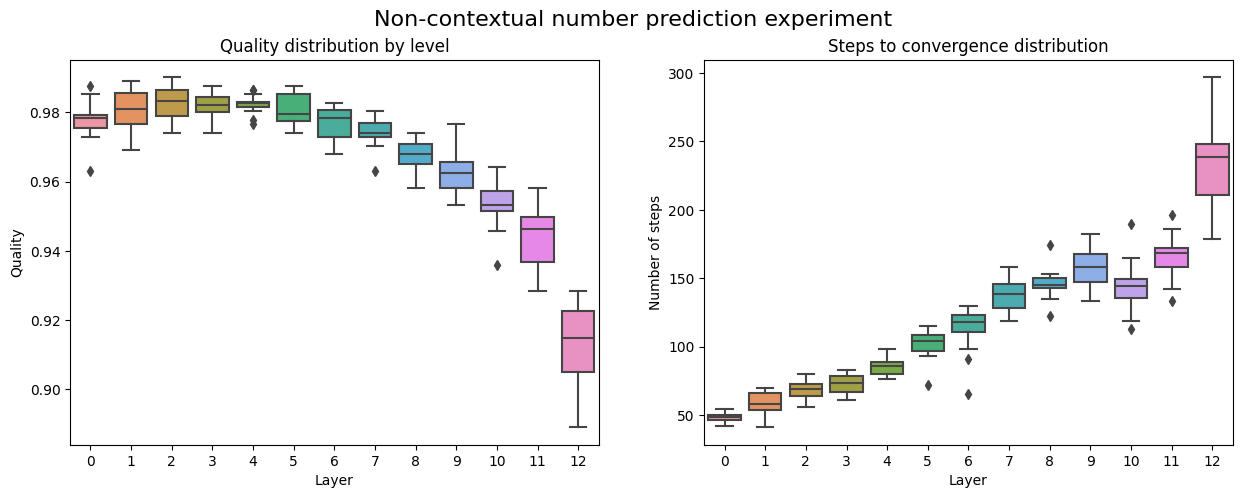

In [53]:
show_results(*separate_word_short(number_parser),\
             "Non-contextual number prediction experiment")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2387 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 6s


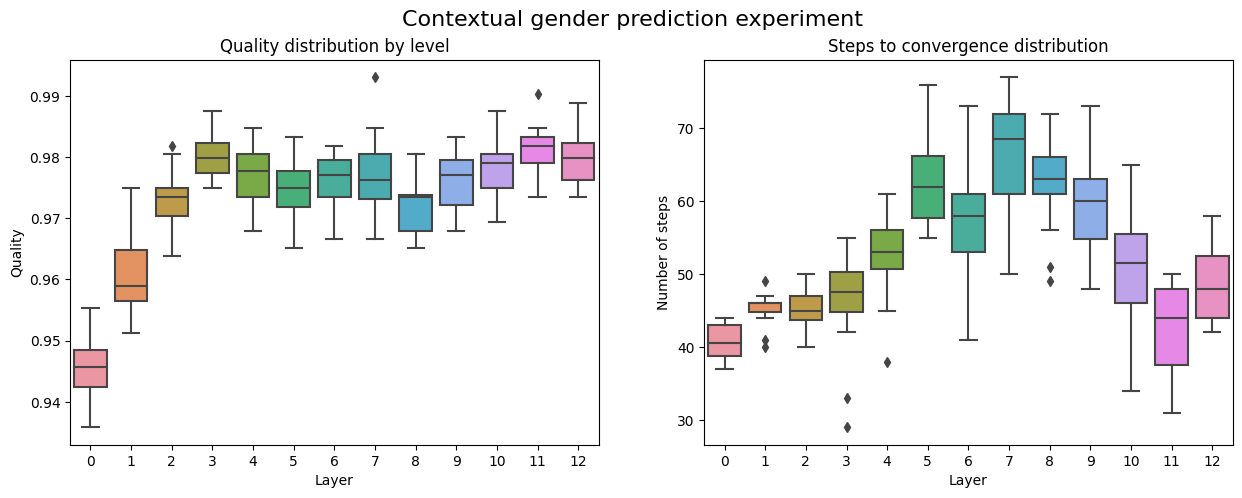

In [55]:
show_results(*word_in_sentence_short(gender_parser),\
             "Contextual gender prediction experiment")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2387 entries in the dataset of width 768
Took 34s
Training the probing classifiers
Took 13s


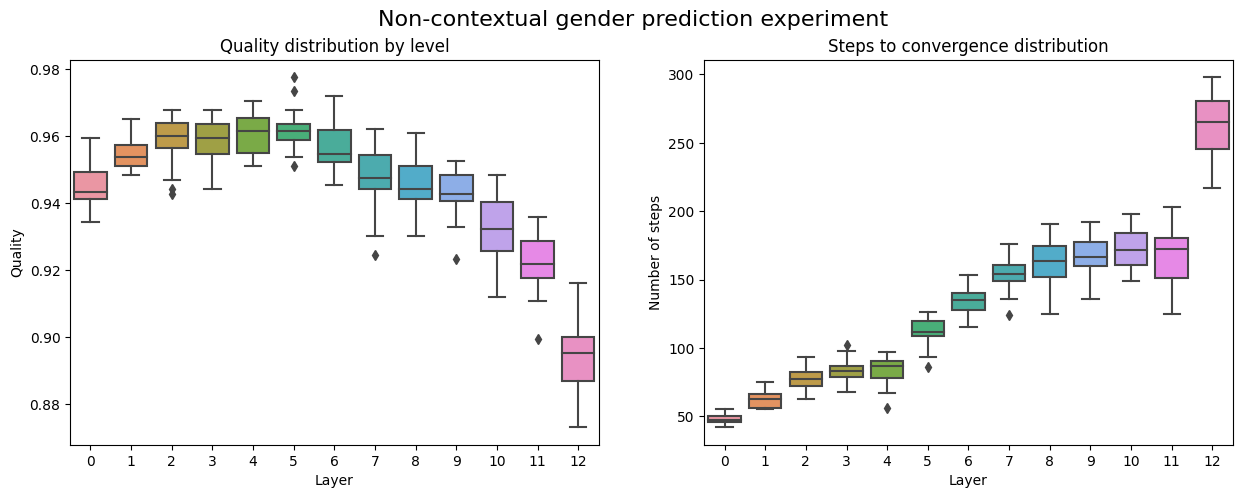

In [56]:
show_results(*separate_word_short(gender_parser),\
             "Non-contextual gender prediction experiment")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 837 entries in the dataset of width 1536
Took 6s
Training probing classifiers
Took 8s


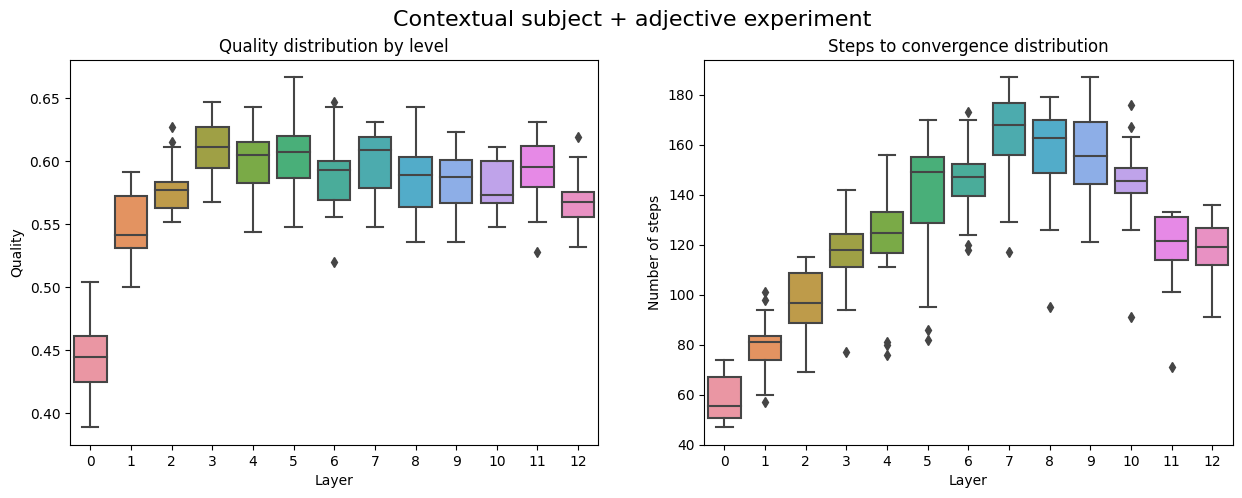

In [47]:
show_results(*word_in_sentence_short(dep_parser),\
             "Contextual subject + adjective experiment")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 837 entries in the dataset of width 1536
Took 21s
Training the probing classifiers
Took 11s


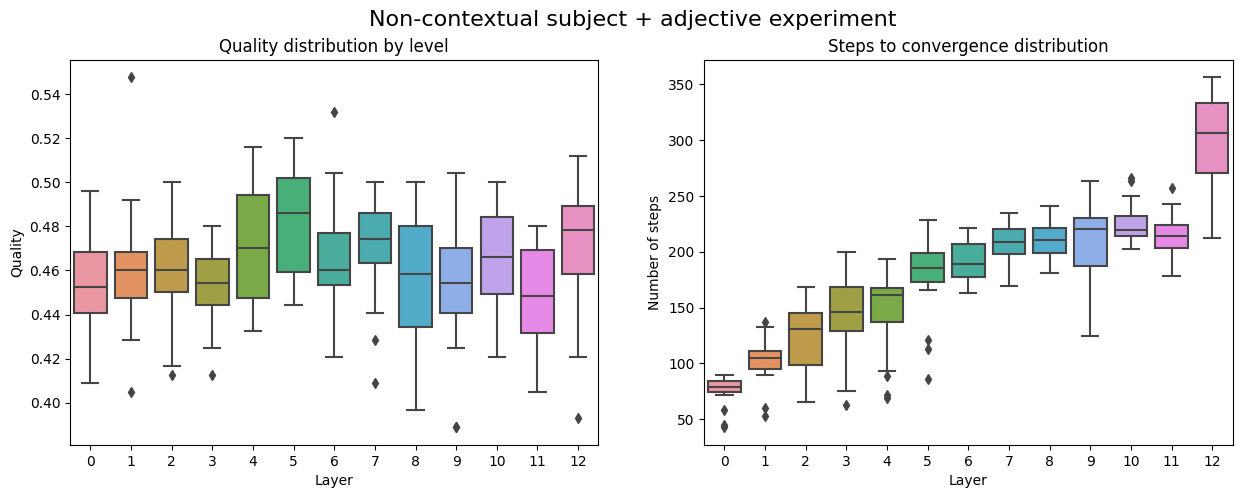

In [48]:
show_results(*separate_word_short(dep_parser),\
             "Non-contextual subject + adjective experiment")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 8393 entries in the dataset of width 768
Took 11s
Training probing classifiers
Took 173s


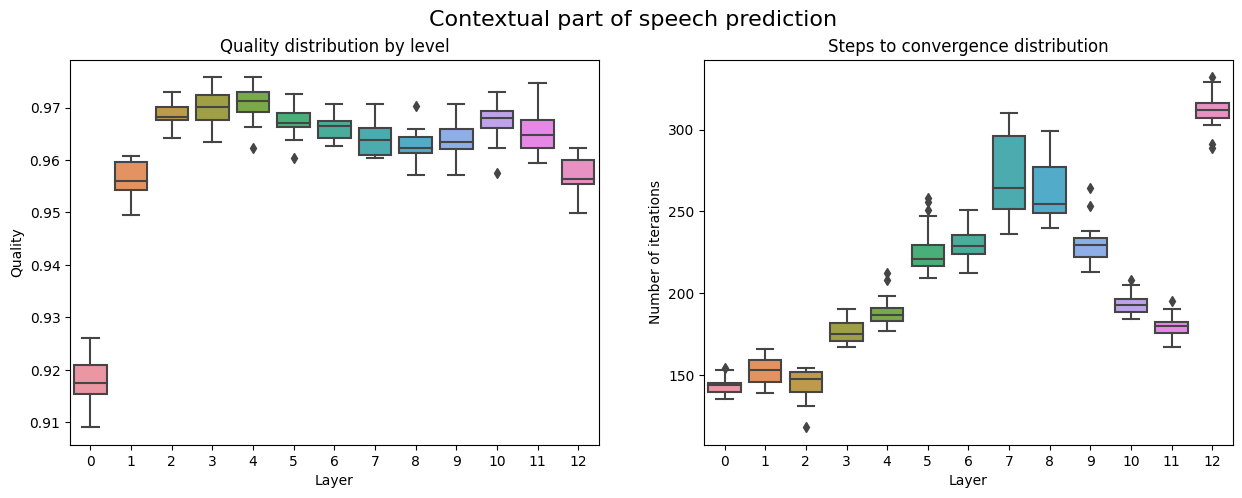

In [19]:
show_results(*word_in_sentence_short(pos_parser),\
             "Contextual part of speech prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 8393 entries in the dataset of width 768
Took 100s
Training the probing classifiers
Took 533s


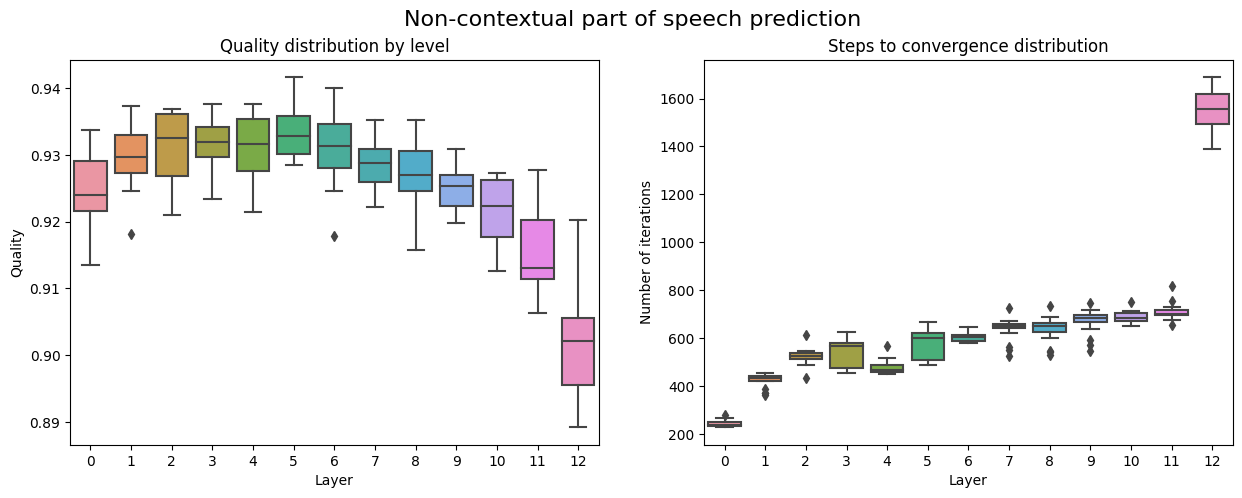

In [20]:
show_results(*separate_word_short(pos_parser),\
             "Non-contextual part of speech prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 886 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 1s


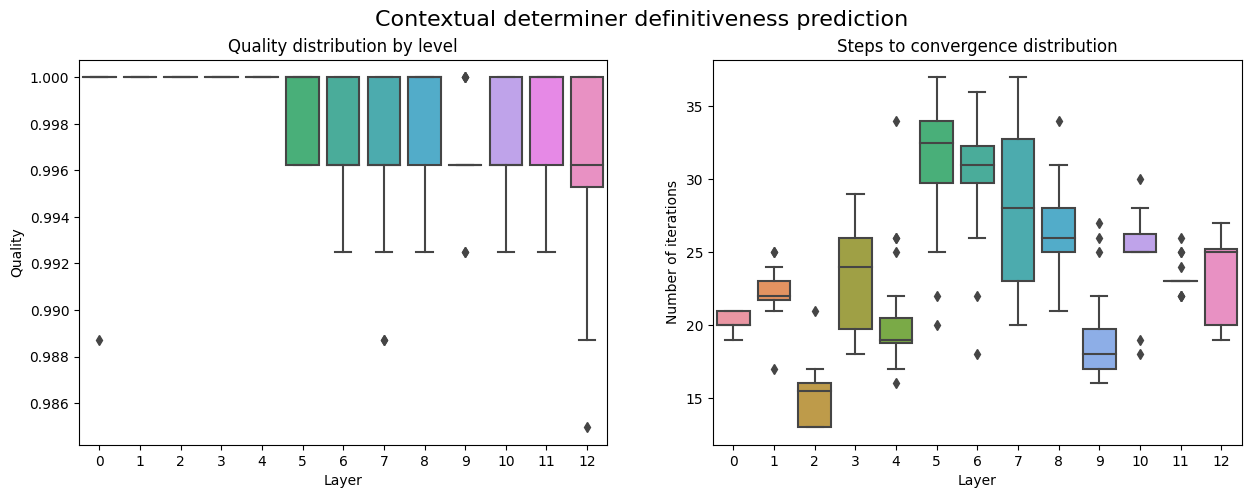

In [21]:
show_results(*word_in_sentence_short(definite_parser),\
             "Contextual determiner definitiveness prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 886 entries in the dataset of width 768
Took 14s
Training the probing classifiers
Took 1s


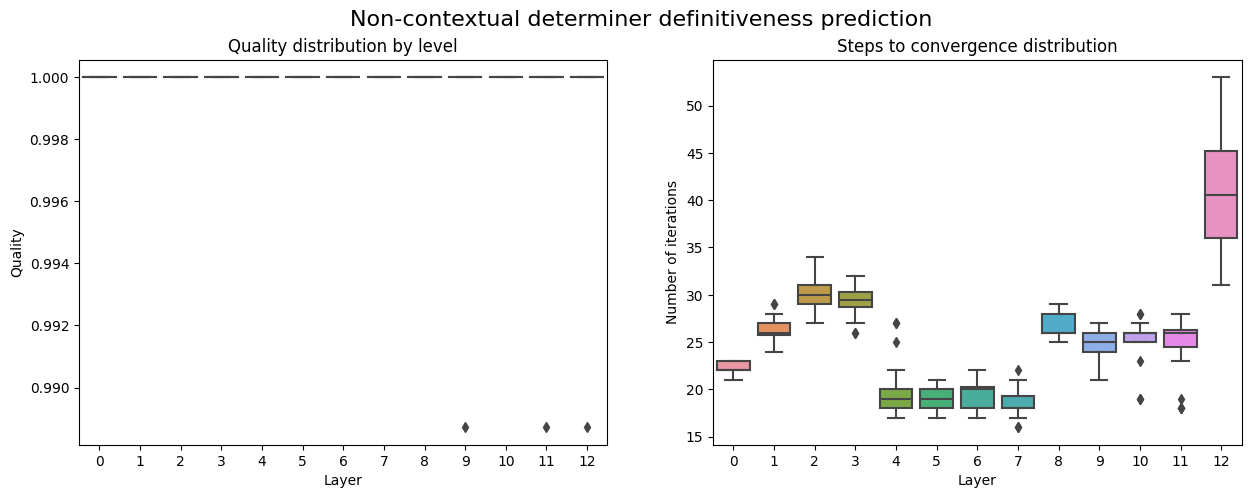

In [22]:
show_results(*separate_word_short(definite_parser),\
             "Non-contextual determiner definitiveness prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 313 entries in the dataset of width 768
Took 6s
Training probing classifiers
Took 1s


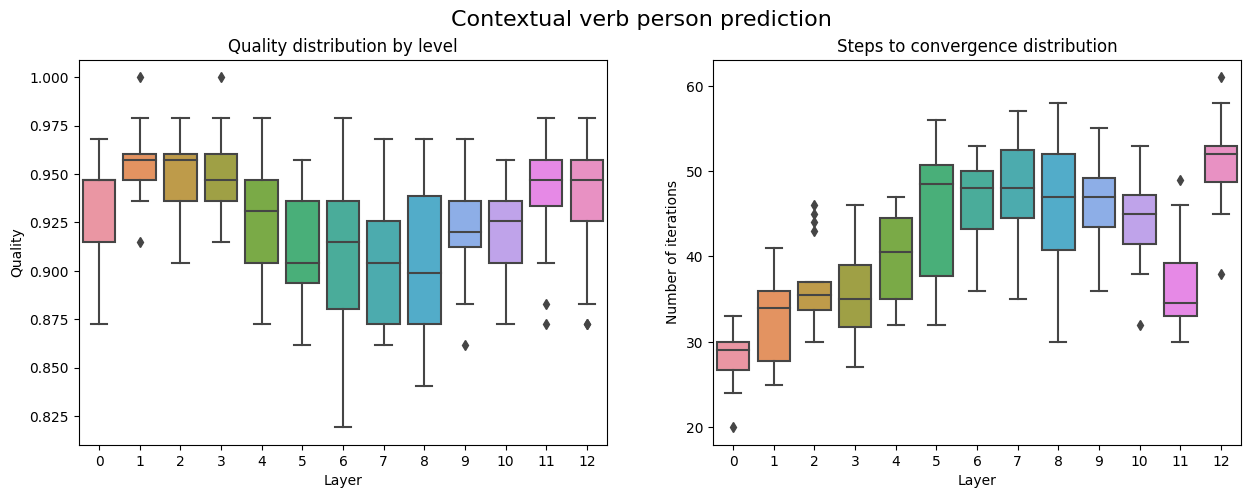

In [23]:
show_results(*word_in_sentence_short(verb_person_parser),\
             "Contextual verb person prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 313 entries in the dataset of width 768
Took 5s
Training the probing classifiers
Took 2s


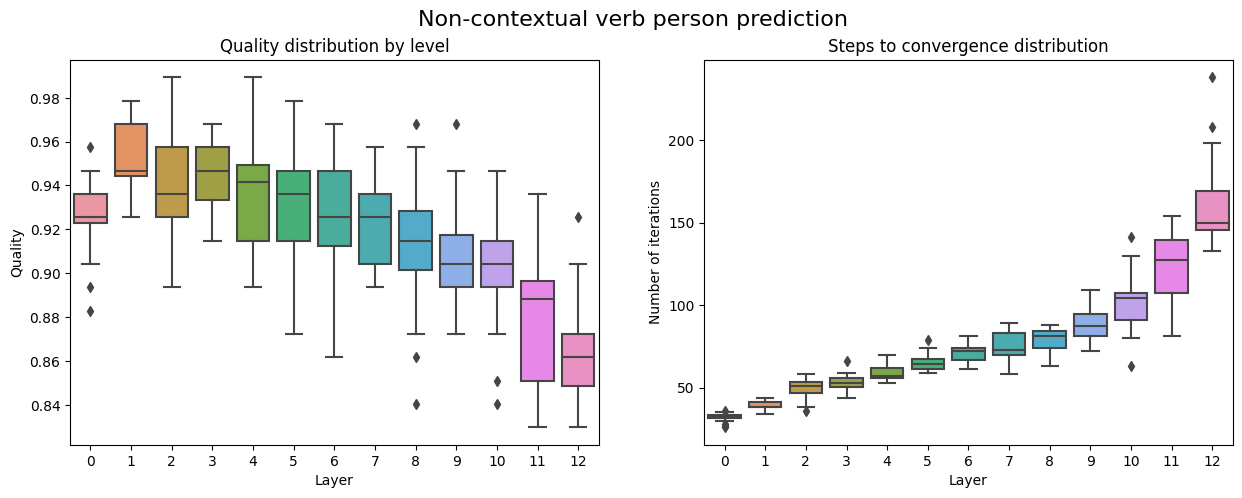

In [24]:
show_results(*separate_word_short(verb_person_parser),\
             "Non-contextual verb person prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 567 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 2s


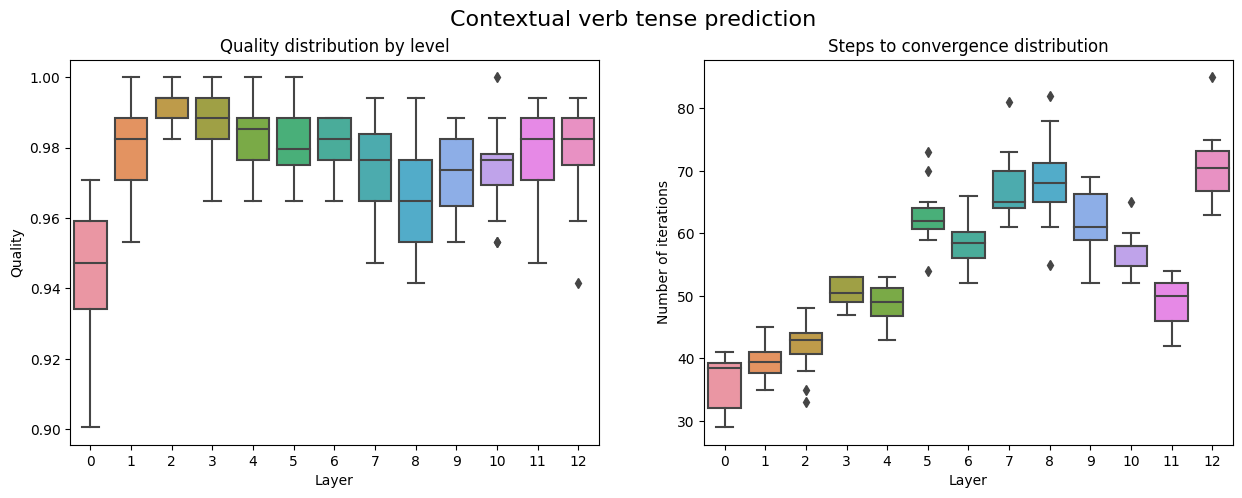

In [25]:
show_results(*word_in_sentence_short(verb_tense_parser),\
             "Contextual verb tense prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 567 entries in the dataset of width 768
Took 7s
Training the probing classifiers
Took 6s


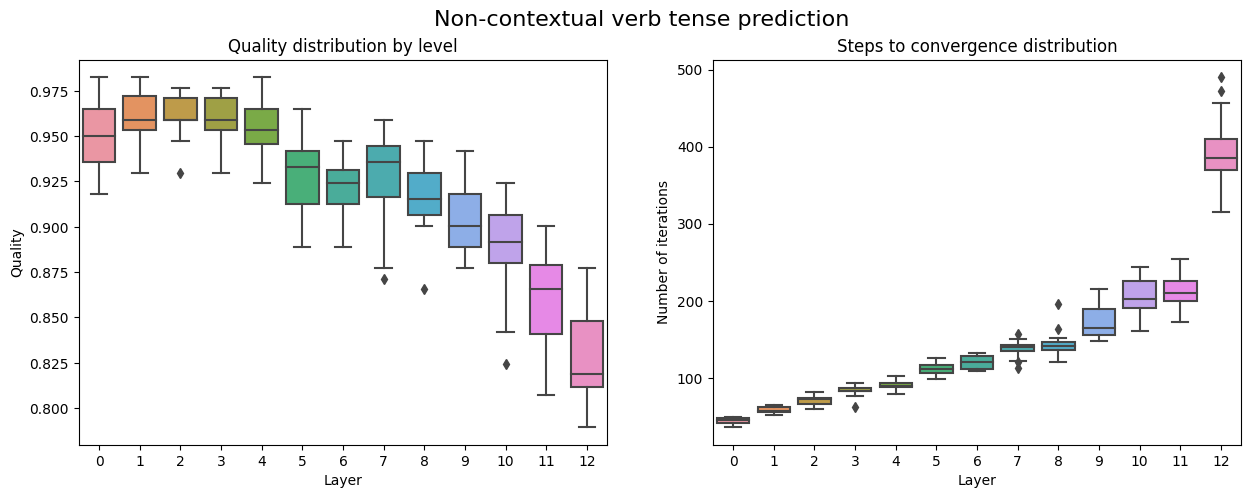

In [26]:
show_results(*separate_word_short(verb_tense_parser),\
             "Non-contextual verb tense prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 313 entries in the dataset of width 768
Took 5s
Training probing classifiers
Took 1s


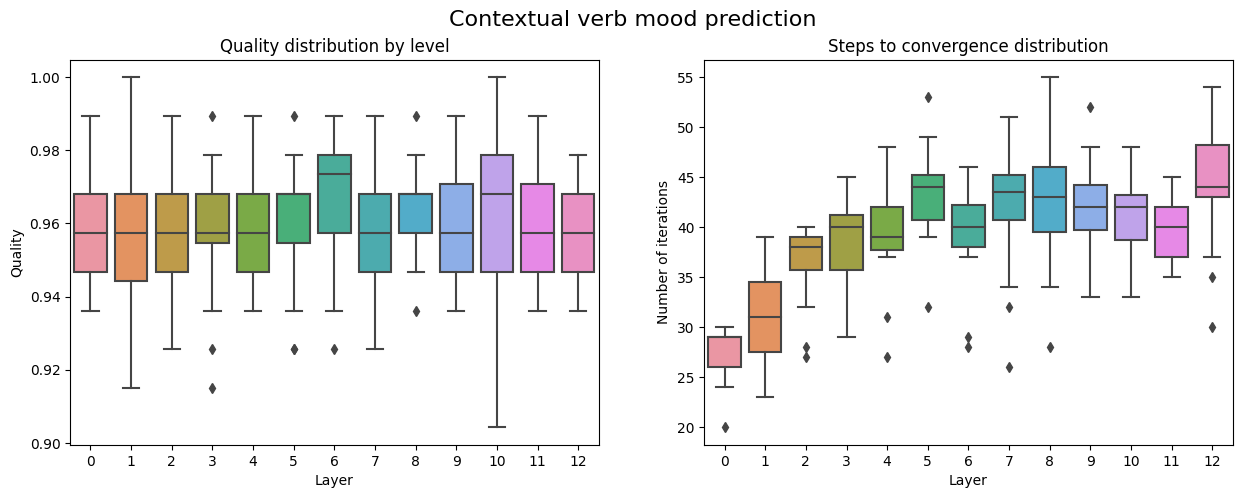

In [27]:
show_results(*word_in_sentence_short(verb_mood_parser),\
             "Contextual verb mood prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 313 entries in the dataset of width 768
Took 4s
Training the probing classifiers
Took 2s


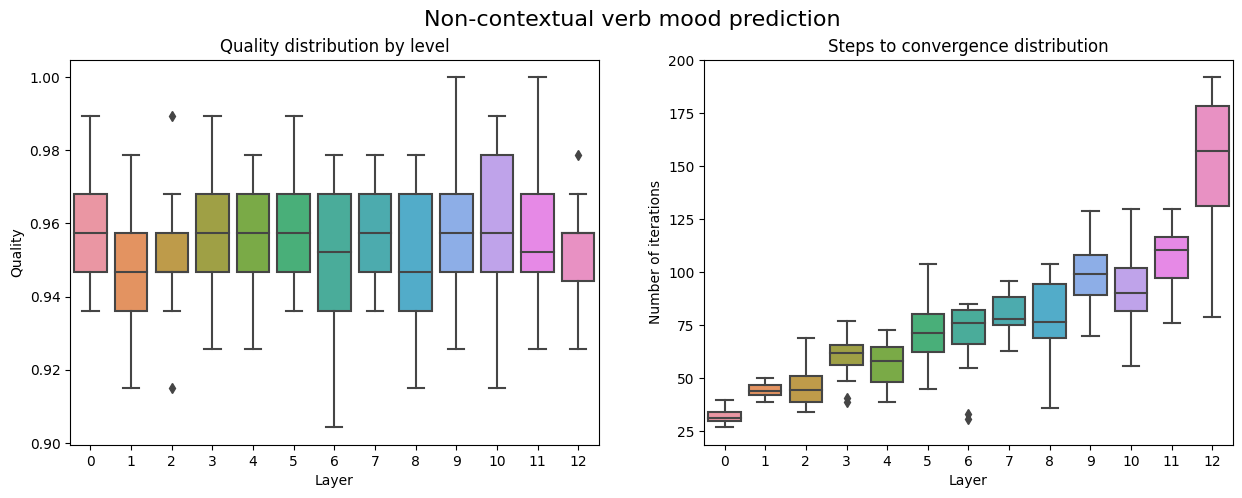

In [28]:
show_results(*separate_word_short(verb_mood_parser),\
             "Non-contextual verb mood prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 726 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 2s


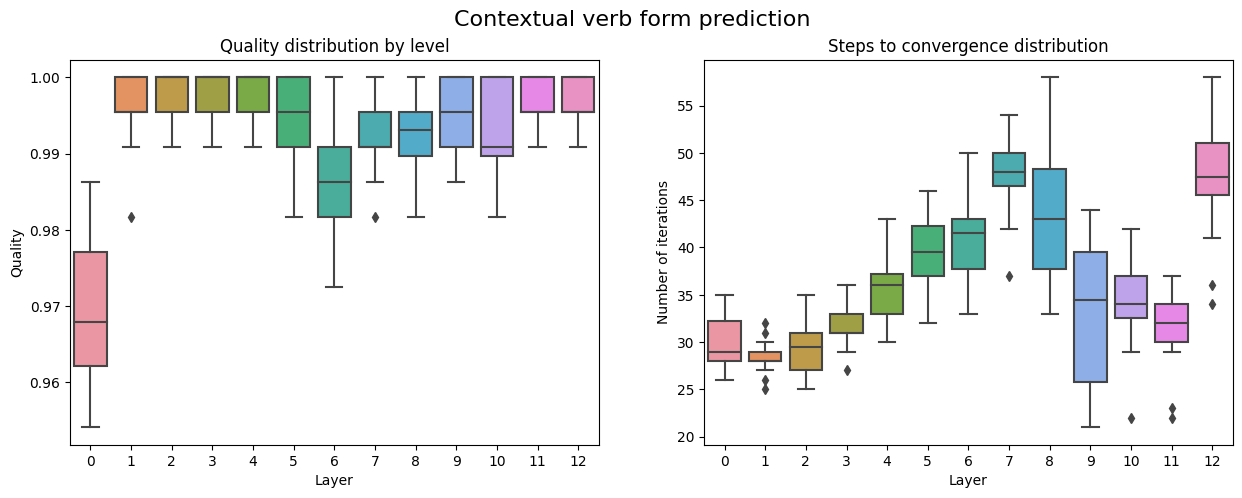

In [29]:
show_results(*word_in_sentence_short(verb_form_parser),\
             "Contextual verb form prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 726 entries in the dataset of width 768
Took 9s
Training the probing classifiers
Took 8s


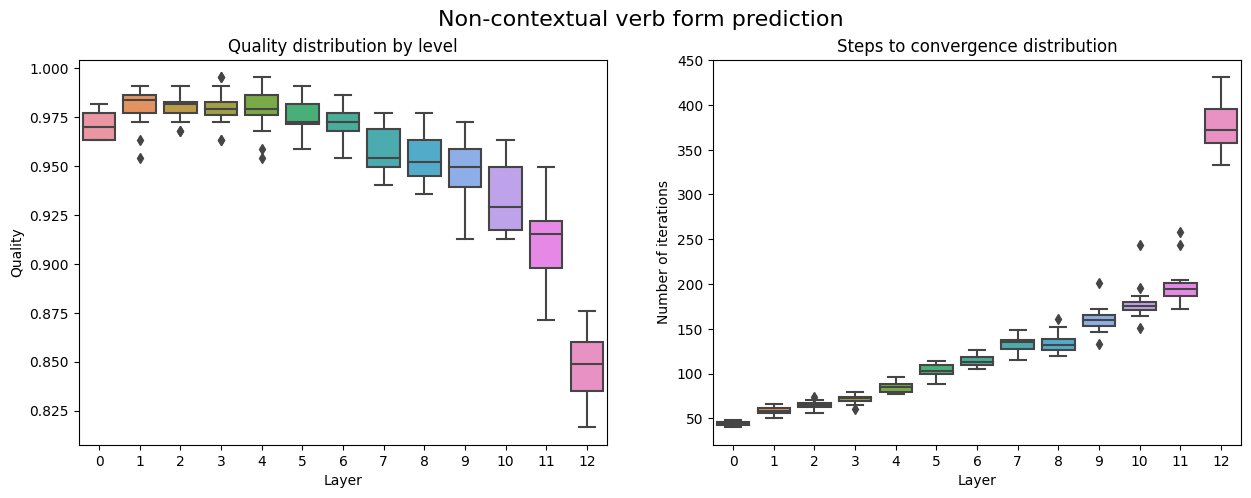

In [30]:
show_results(*separate_word_short(verb_form_parser),\
             "Non-contextual verb form prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 480 entries in the dataset of width 768
Took 6s
Training probing classifiers
Took 3s


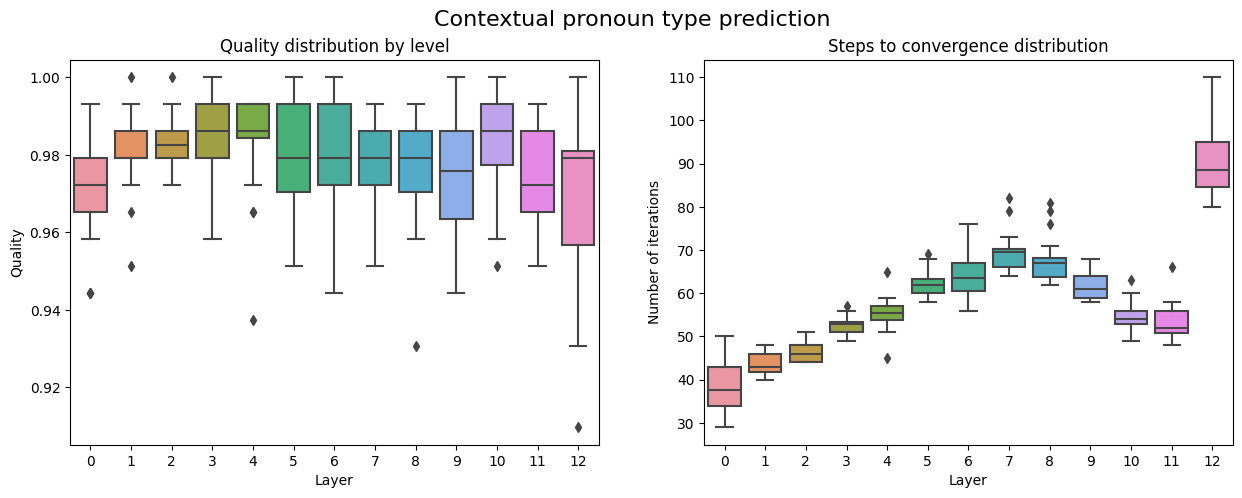

In [31]:
show_results(*word_in_sentence_short(pron_type_parser),\
             "Contextual pronoun type prediction")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 480 entries in the dataset of width 768
Took 6s
Training the probing classifiers
Took 3s


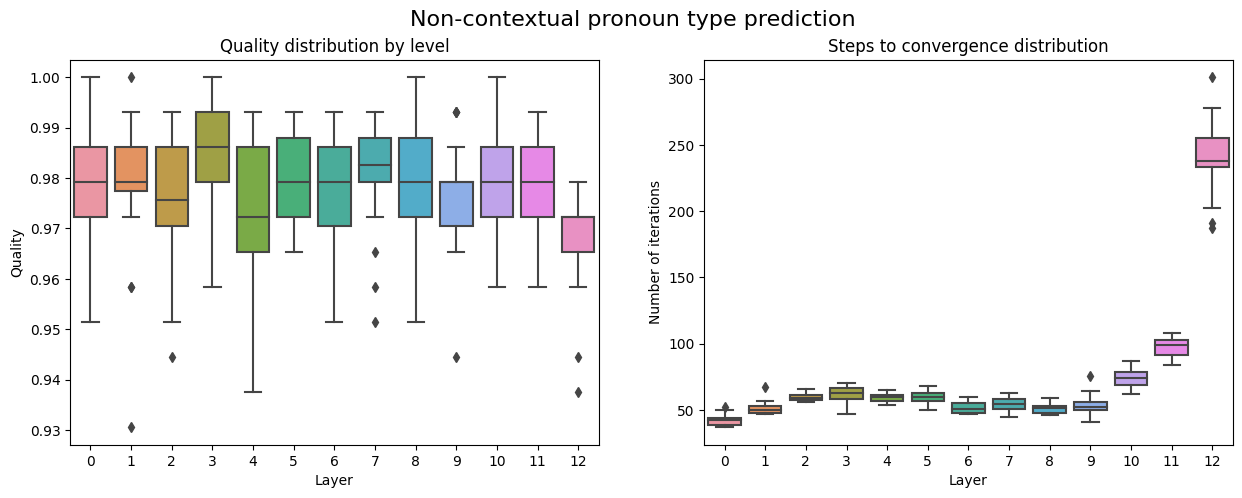

In [32]:
show_results(*separate_word_short(pron_type_parser),\
             "Non-contextual pronoun type prediction")

### Distancing along the sentence categorical experiments

In [79]:
distance_number_parser_1 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 1, 6)
distance_number_parser_2 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 2, 6)
distance_number_parser_3 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 3, 6)
distance_number_parser_4 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 4, 6)
distance_number_parser_5 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 5, 6)
distance_number_parser_6 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 6, 6)

distance_pronoun_type_parser_1 = lambda feats, _: get_word_by_word_with_distance(feats, ["PRON"], "PronType", 1, 4)
distance_pronoun_type_parser_2 = lambda feats, _: get_word_by_word_with_distance(feats, ["PRON"], "PronType", 2, 4)

distance_det_def_parser_1 = lambda feats, _: get_word_by_word_with_distance(feats, ["DET"], "Definite", 1, 4)
distance_det_def_parser_2 = lambda feats, _: get_word_by_word_with_distance(feats, ["DET"], "Definite", 2, 4)

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2025 entries in the dataset of width 768
Took 8s
Training probing classifiers
Took 6s


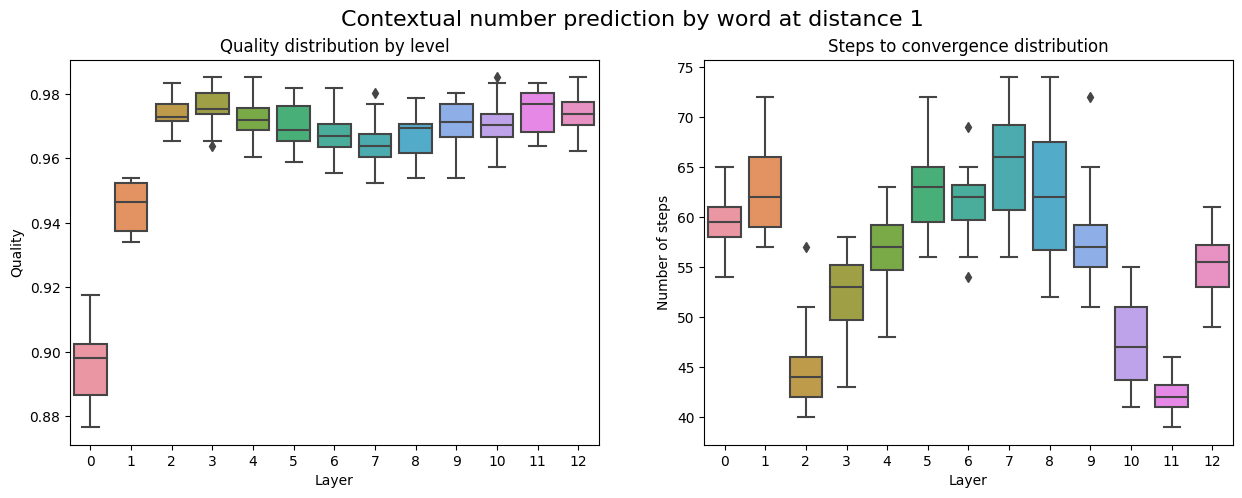

In [66]:
show_results(*word_in_sentence_short(distance_number_parser_1),\
             "Contextual number prediction by word at distance 1")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2025 entries in the dataset of width 768
Took 12s
Training probing classifiers
Took 7s


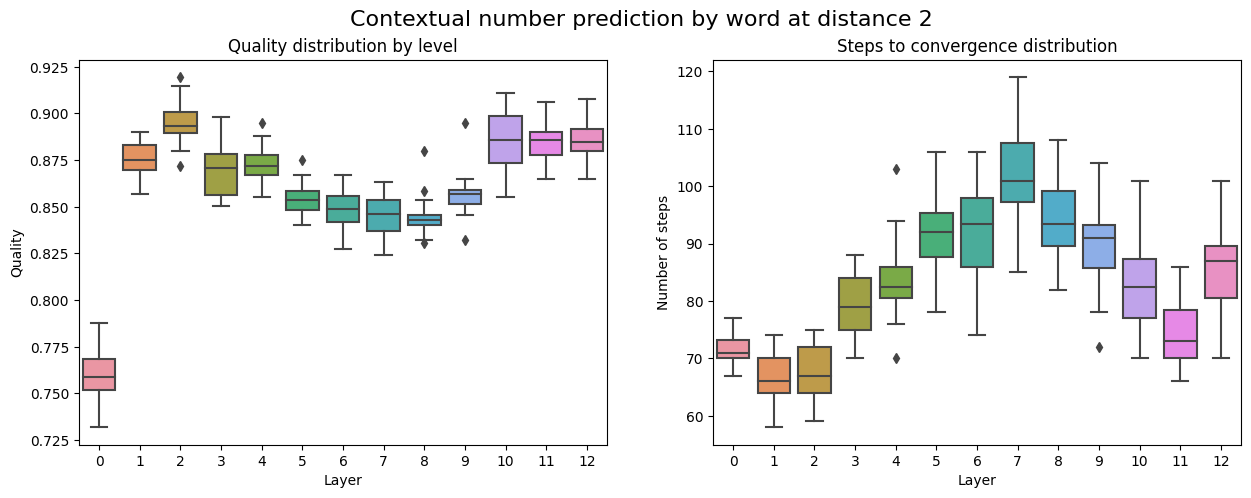

In [67]:
show_results(*word_in_sentence_short(distance_number_parser_2),\
             "Contextual number prediction by word at distance 2")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2025 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 9s


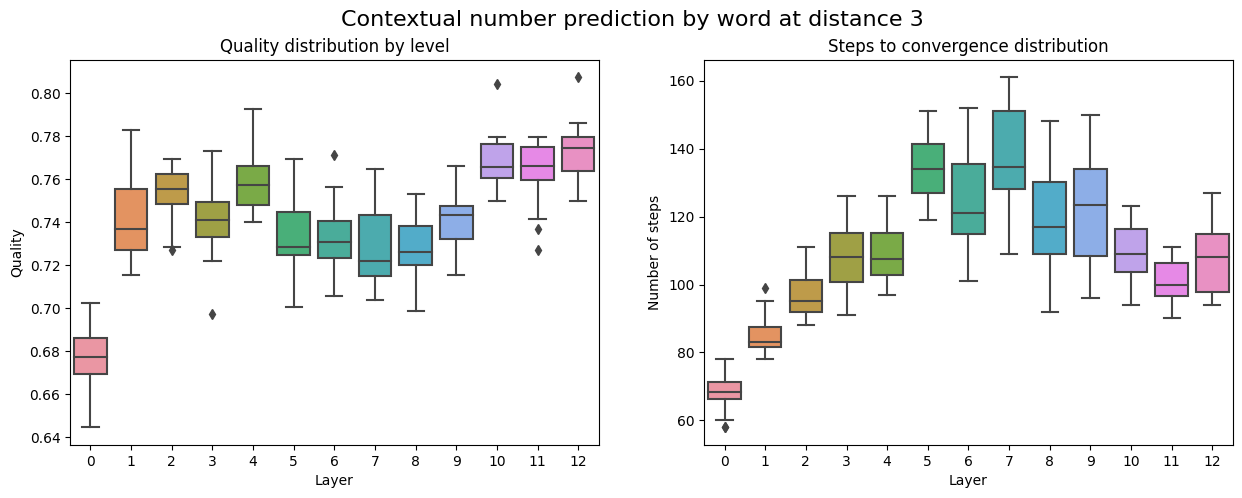

In [68]:
show_results(*word_in_sentence_short(distance_number_parser_3),\
             "Contextual number prediction by word at distance 3")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2025 entries in the dataset of width 768
Took 10s
Training probing classifiers
Took 9s


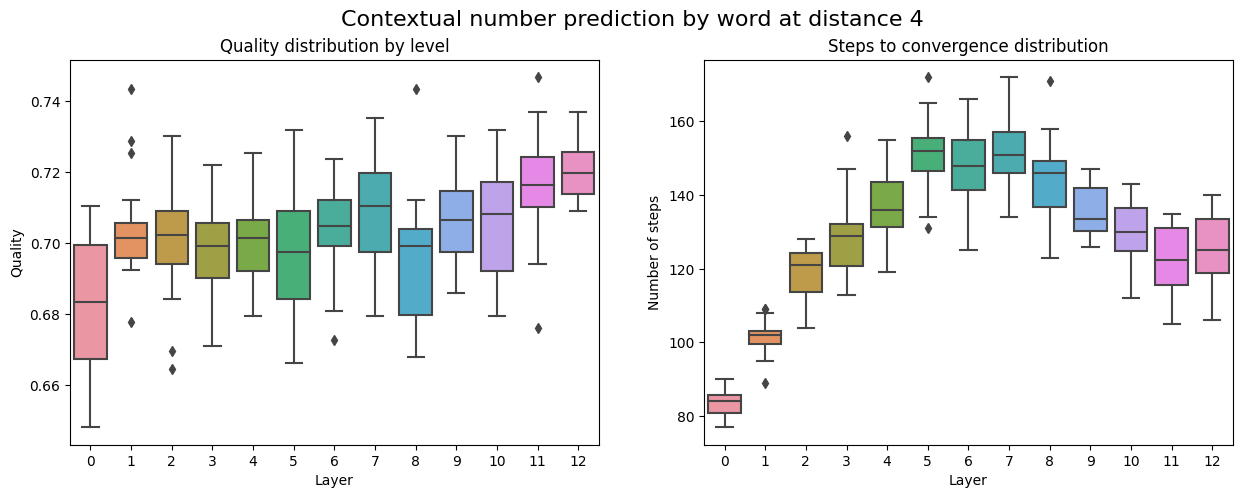

In [69]:
show_results(*word_in_sentence_short(distance_number_parser_4),\
             "Contextual number prediction by word at distance 4")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2025 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 9s


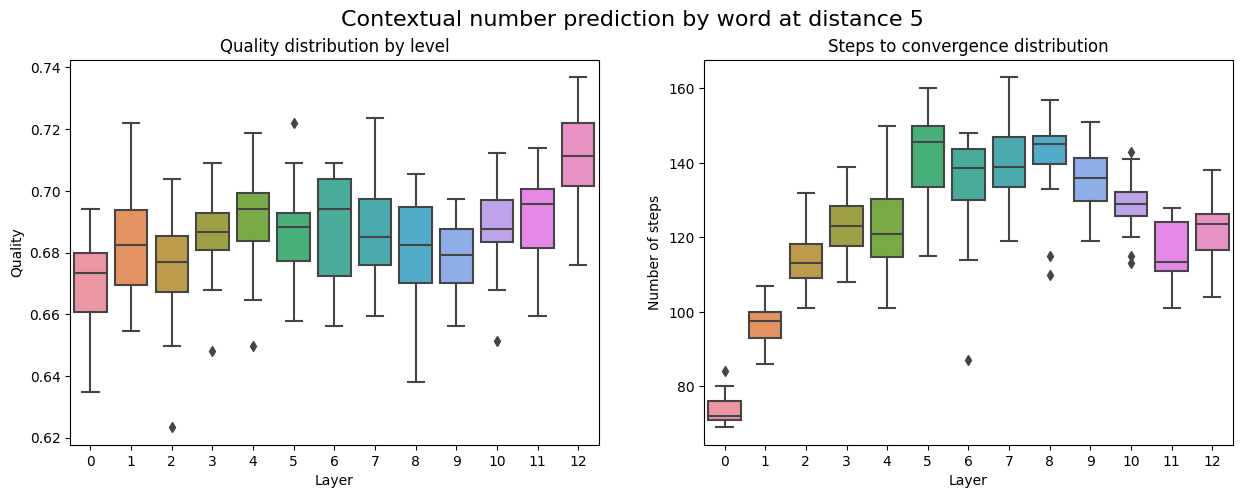

In [70]:
show_results(*word_in_sentence_short(distance_number_parser_5),\
             "Contextual number prediction by word at distance 5")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 2025 entries in the dataset of width 768
Took 9s
Training probing classifiers
Took 10s


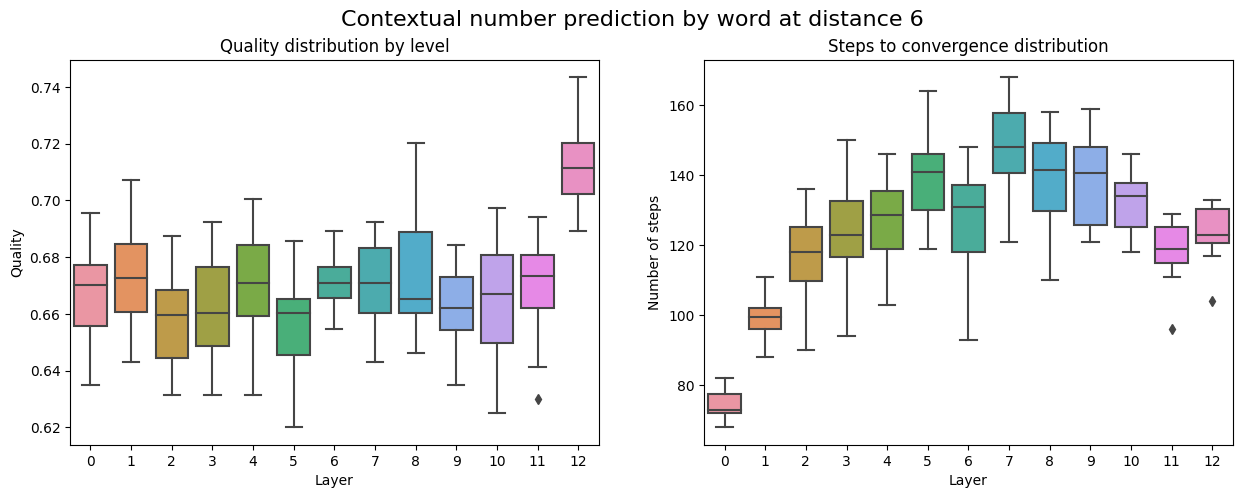

In [71]:
show_results(*word_in_sentence_short(distance_number_parser_6),\
             "Contextual number prediction by word at distance 6")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 736 entries in the dataset of width 768
Took 4s
Training probing classifiers
Took 1s


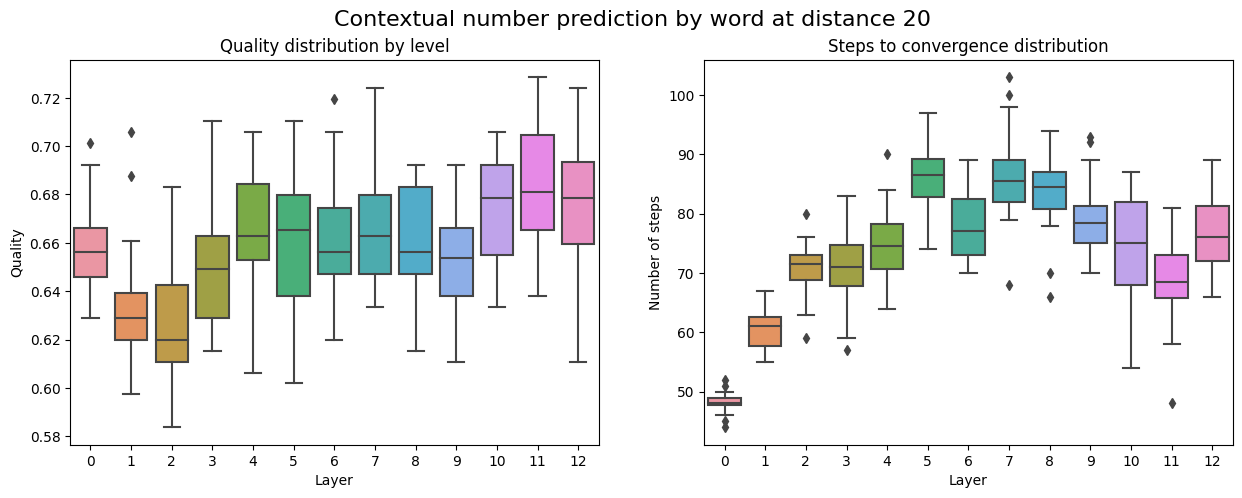

In [72]:
distance_number_parser_20 = lambda feats, _: get_word_by_word_with_distance(feats, ["NOUN", "VERB", "ADJ"], "Number", 20, 20)
show_results(*word_in_sentence_short(distance_number_parser_20),\
             "Contextual number prediction by word at distance 20")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 305 entries in the dataset of width 768
Took 4s
Training probing classifiers
Took 3s


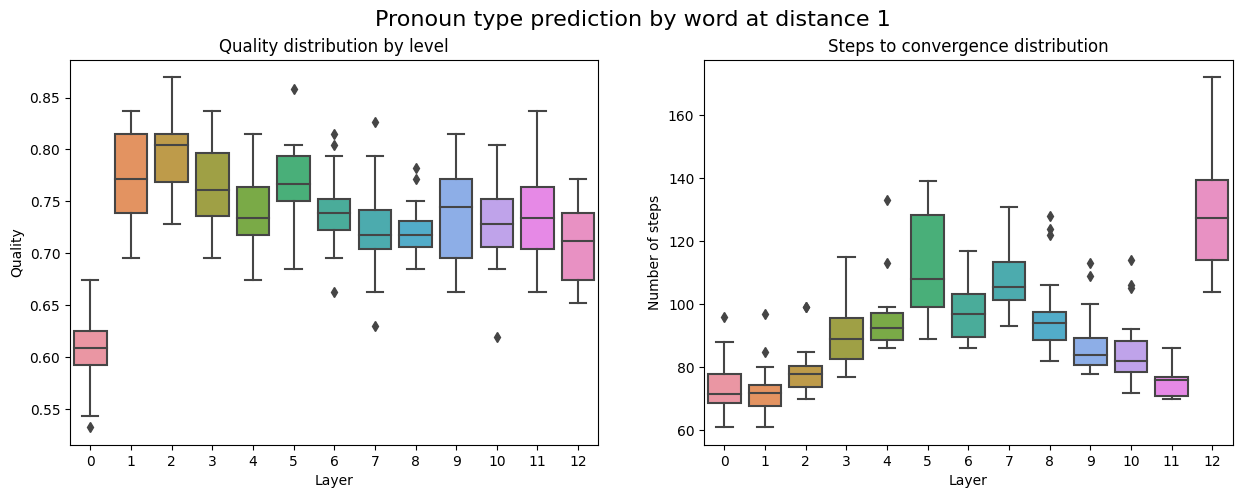

In [80]:
show_results(*word_in_sentence_short(distance_pronoun_type_parser_1),\
             "Pronoun type prediction by word at distance 1")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 305 entries in the dataset of width 768
Took 4s
Training probing classifiers
Took 3s


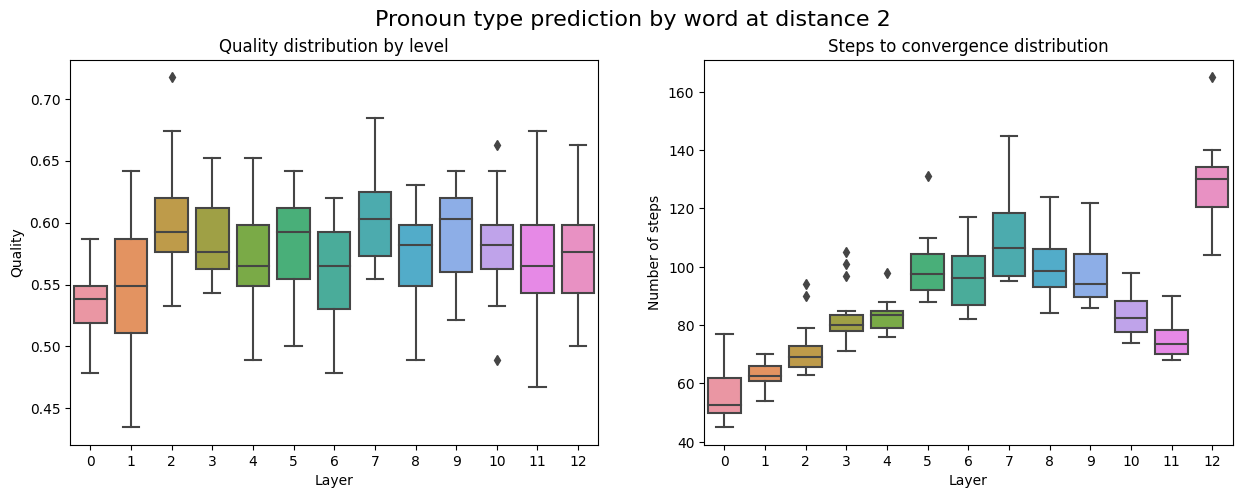

In [81]:
show_results(*word_in_sentence_short(distance_pronoun_type_parser_2),\
             "Pronoun type prediction by word at distance 2")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 709 entries in the dataset of width 768
Took 7s
Training probing classifiers
Took 1s


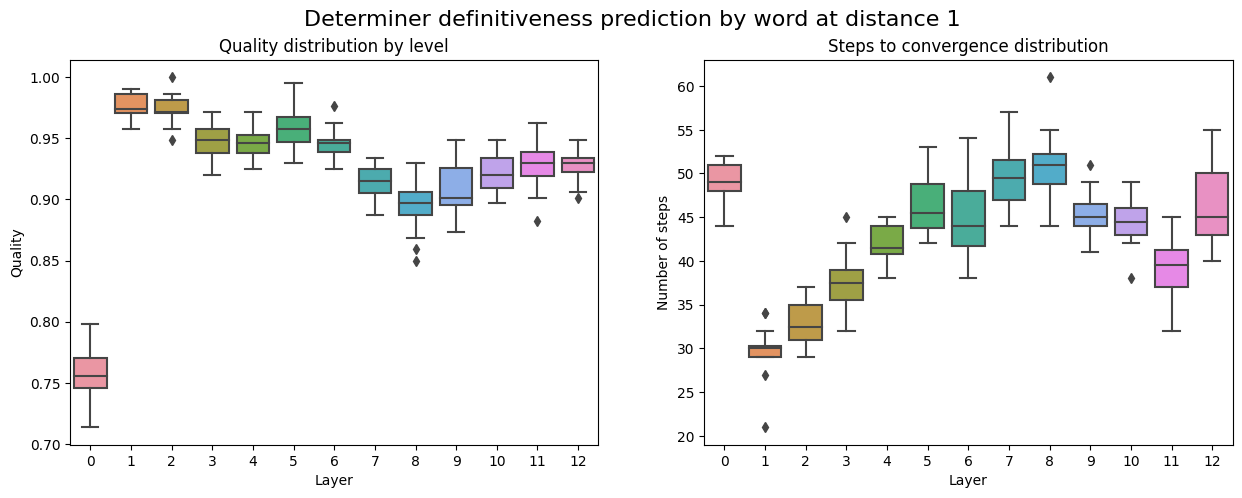

In [84]:
show_results(*word_in_sentence_short(distance_det_def_parser_1),\
             "Determiner definitiveness prediction by word at distance 1")

Loading sentences...
38 out of 416 failed
Took 0s
Getting embeddings...
Got 13 layers, 709 entries in the dataset of width 768
Took 7s
Training probing classifiers
Took 1s


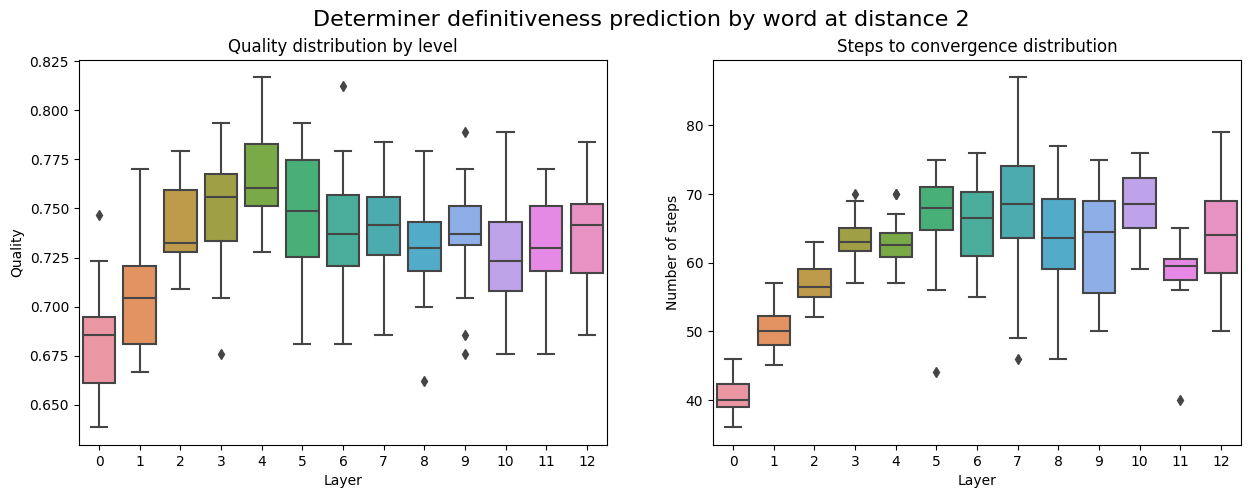

In [85]:
show_results(*word_in_sentence_short(distance_det_def_parser_2),\
             "Determiner definitiveness prediction by word at distance 2")